### Steps to process tiffs without imageJ

install steps

*** didn't actually use this but could be useful sometime
from
https://github.com/clEsperanto/pyclesperanto_prototype/tree/master

pip install pyclesperanto-prototype

install CPU support if no GPU
for Linux
conda install  pocl -c conda-forge

for Windows
conda install  oclgrind -c conda-forge
***


1. download tiff

2. load in using imageio as numpy array

3. reshape to an array with 3 as a dimension

4. divide into chunks, do maximum z projection, and save using function below 


try using suite2p

In [1]:
from pathlib import Path
import imageio
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FILE = Path("C:/Users/jmc010/Data/2p_testing/file_00002.tif")

In [3]:
tic = time.time()
im = imageio.imread(FILE)
toc = time.time()

print(f"Time taken is {toc-tic} s")

C:\Users\jmc010\AppData\Local\Temp\ipykernel_16532\2495431696.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(FILE)


Time taken is 36.83854556083679 s


In [4]:
# removes leftover frames from end
def remove_leftover_frames(im):
    rem = im.shape[0] % 3
    im = im[:-rem,:,:]
    
    return im

In [5]:
# reshapes image
def reshape_array(im, zplanes=3):
    nframes, y, x = im.shape
    im = im.reshape(((int(nframes / zplanes)), -1, y, x))
    
    return im

In [6]:
# im = remove_leftover_frames(im)
im2 = im[:300,:,:]
im3 = reshape_array(im2)

In [7]:
im3.shape

(100, 3, 512, 512)

In [8]:
im4 = np.mean(im3, axis=1)

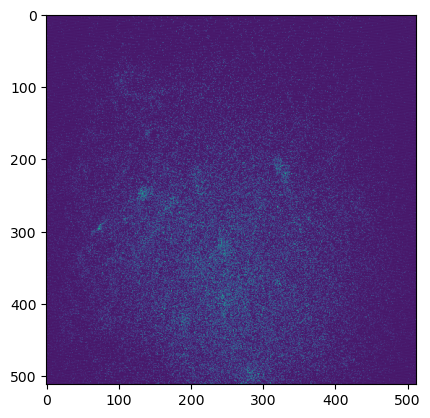

In [11]:
plt.imshow(im4[5,:,:])

In [19]:
def process_in_chunks(im, chunk_size, filepath):
    
    if chunk_size % 3 != 0:
        print("chunk_size must be divisible by 3. Exiting.")
        return
    
    print(f"Processing with chunk_size={chunk_size}")
    
    # Calculate the number of chunks
    num_chunks = len(im) // chunk_size + (len(im) % chunk_size > 0)
    
    for i in range(num_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size
        chunk = im[start:end,:,:]

        im2save = np.max(reshape_array(chunk), axis=1)
        print(im2save.shape)
        
        output_filename = f"{filepath}chunk_{i}.tif"
        imageio.mimwrite(output_filename, im2save, format='TIFF')
        
    print("Finished saving chunks")

im2 = im[:4800,:,:]
process_in_chunks(im2, 1800, "C:/Users/jmc010/Data/2p_testing/processed_max/")

Processing with chunk_size=1800
(600, 512, 512)
(600, 512, 512)
(400, 512, 512)
Finished saving chunks


In [20]:
# probably best not to do rolling average before registration but maybe afterwards on registered tiffs?

from scipy.ndimage import uniform_filter

def process_in_chunks_and_average(im, chunk_size, filepath):
    
    if chunk_size % 3 != 0:
        print("chunk_size must be divisible by 3. Exiting.")
        return
    
    print(f"Processing with chunk_size={chunk_size}")
    
    # Calculate the number of chunks
    num_chunks = len(im) // chunk_size + (len(im) % chunk_size > 0)
    
    for i in range(num_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size
        chunk = im[start:end,:,:]

        im_max = np.max(reshape_array(chunk), axis=1)
        
        window_size = 3
        axis = 0  # Rolling average along the t-axis

        # Calculate the rolling average
        im2save = uniform_filter(im_max, size=window_size, axis=axis)

        print(im2save.shape)
        
        output_filename = f"{filepath}chunk_{i}.tif"
        imageio.mimwrite(output_filename, im2save, format='TIFF')
        
    print("Finished saving chunks")

im2 = im[:4800,:,:]
process_in_chunks(im2, 1800, "C:/Users/jmc010/Data/2p_testing/processed_roll/")

Processing with chunk_size=1800
(600, 512, 512)
(600, 512, 512)
(400, 512, 512)
Finished saving chunks


In [23]:
# try loading in registered tiffs?

reg_path = Path("C:/Users/jmc010/Data/2p_testing/processed_max/suite2p/plane0/reg_tif")

filenames = [file.name for file in reg_path.iterdir() if file.is_file()]

print(filenames)

data = []
for file in filenames:
    data.append(imageio.imread(reg_path / file))

['file00000_chan0.tif', 'file001000_chan0.tif', 'file001500_chan0.tif', 'file00500_chan0.tif']


C:\Users\jmc010\AppData\Local\Temp\ipykernel_16532\2377088002.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  data.append(imageio.imread(reg_path / file))


In [29]:
data[0].shape
len(data)

4

In [25]:
all_frames = np.concatenate(data)

In [26]:
all_frames.shape

(2048, 512)

In [ ]:
# also try using "best" zplane and see how it looks
# separate out zplanes and pick the best one then go from there

In [ ]:
# testing data - 9 frames with 4(Y) x 2(X)

frame1 = np.array([[1, 0], [0, 0], [0, 0], [0, 0]])
frame2 = np.array([[2, 0], [0, 0], [0, 0], [0, 0]])
frame3 = np.array([[3, 0], [0, 0], [0, 0], [0, 0]])

frame4 = np.array([[0, 0], [0, 1], [0, 0], [0, 0]])
frame5 = np.array([[0, 0], [0, 3], [0, 0], [0, 0]])
frame6 = np.array([[0, 0], [0, 2], [0, 0], [0, 0]])

frame7 = np.array([[0, 0], [0, 0], [0, 0], [0, 1]])
frame8 = np.array([[0, 0], [0, 0], [0, 0], [0, 2]])
frame9 = np.array([[0, 0], [0, 0], [0, 0], [0, 3]])

im = np.array([frame1, frame2, frame3, frame4, frame5, frame6, frame7, frame8, frame9])

im.shape


In [ ]:
im2 = reshape_array(im)
im2.shape

In [ ]:
im3 = np.mean(im2, axis=1)
im3.shape

In [ ]:
plt.imshow(im3[2,:,:])

In [ ]:
def get_z_project(im):
    
    print(im.shape)
    nframes = im.shape[0]
    result = np.zeros((nframes, im.shape[2], im.shape[3]))
    for idx in range(nframes):
        result[idx,:,:] = np.max(im[idx,:,:,:], axis=0)
        
    return result

get_z_project(im)